<img src="images/logo/selene-logo-640.png" style="max-height:75px;" alt="SELENE Logo" />

**Disclaimer:** This Jupyter Notebook contains content generated with the assistance of AI. While every effort has been made to review and validate the outputs, users should independently verify critical information before relying on it. The SELENE notebook repository is constantly evolving. We recommend downloading or pulling the latest version of this notebook from Github.

# Text Classification with Recurrent Neural Networks (RNNs)

Text classification is a fundamental task in natural language processing (NLP) that involves assigning predefined categories to text data. One effective approach for text classification is using recurrent neural networks (RNNs), which are well-suited for sequential data such as sentences and documents. In this context, we consider the task of classifying news article headlines into categories such as business, education, entertainment, sports, and technology. Since headlines are typically short and lack extensive context, a powerful model is required to capture the semantic relationships between words.

To handle this challenge, we use a specialized type of RNN called a Long Short-Term Memory (LSTM) network. LSTMs address the limitations of traditional RNNs by incorporating memory cells that can retain information over longer sequences, preventing issues like vanishing gradients. This makes LSTMs particularly effective in understanding the meaning of short but contextually rich text, such as news headlines. By processing each word sequentially and learning the dependencies between them, an LSTM can generate meaningful representations of headlines and accurately predict their categories. By leveraging the ability of LSTMs to capture sequential patterns, this approach enables accurate classification of news headlines into relevant categories.

Apart from using LSTM as the RNN variant of choice, we otherwise keep the network model purposefully very simple &mdash; this means:
* **No** multilayer RNN architecture
* **No** bi-directional RNN architecture
* **No** attention mechanism

Adding such improvements is relatively straightforward, but adds quite some overhead to the otherwise rather simple implementations, and here we want to focus on understanding the core steps when using RNNs for text classification.

### Setting up the Notebook

#### Make Required Imports

This notebook requires the import of different Python packages but also additional Python modules that are part of the repository. If a package is missing, use your preferred package manager (e.g., [conda](https://anaconda.org/anaconda/conda) or [pip](https://pypi.org/project/pip/)) to install it. If the code cell below runs with any errors, all required packages and modules have successfully been imported.

In [1]:
from src.text.vectorizing.vocab import Vocabulary
from src.utils.libimports.rnntextclass import *
from src.utils.plotting.nn import *
from src.utils.compute.gpu import *
from src.utils.data.files import *

#### Download Required Data

Some code examples in this notebook use data that first need to be downloaded by running the code cell below. If this code cell throws any error, please check the configuration file `config.yaml` if the URL for downloading datasets is up to date and matches the one on Github. If not, simply download or pull the latest version from Github.

In [2]:
news, _ = download_dataset("text/classification/news-classification/news-classification-dataset.csv")

File 'data/datasets/text/classification/news-classification/news-classification-dataset.csv' already exists (use 'overwrite=True' to overwrite it).


#### Checking & Setting Computing Device

PyTorch allows to train neural networks on supported GPU to significantly speed up the training process. If you have a support GPU, feel free to utilize it. However, for this notebook it's certainly not needed as our dataset is small and our network model is very simple. We provide an auxiliary method to automatically select the best device. It checks if a supported GPU is available and if so, uses it as the preferred device.

In [3]:
# Select preferred device (GPU, if available; CPU otherwise); you can enfore the use of the CPU
device = select_device(force_cpu=False)

print("Available device: {}".format(device))

Available device: cuda:0


---

## Data Preparation

### Loading the Dataset

In this notebook, we consider a [publicly available](https://www.kaggle.com/datasets/banuprakashv/news-articles-classification-dataset-for-nlp-and-ml) dataset containing 10,000 new articles from "The Indian Express" online news site. Each news article has a headline, a brief summary or description, and a category (business, education, entertainment, sports, or technology). The text classification model we will train in this notebook is to predict the category of a news article based solely on its headline. Let's first load the dataset from the file into Pandas DataFrame for further processing. Since we only consider the headline and the category of each article, we drop the column containing the description.

In [4]:
# Load file into Pandas DataFrame
df_news = pd.read_csv(news)
# Drop column "description"
df_news = df_news.drop("description", axis=1)
# Print the first 5 row of DataFrame
df_news.head()

headline  category
0  Nirmala Sitharaman to equal Morarji Desai’s re...  business
1  ‘Will densify network, want to be at least no....  business
2  Air India group to induct an aircraft every si...  business
3  Red Sea woes: Exporters seek increased credit ...  business
4  Air India group to induct a plane every 6 days...  business

### Encoding the News Categories

When training a machine learning classifier using PyTorch, class labels must be converted to integers ranging from $0$ to $(\#\text{classes} - 1)$ because PyTorch's loss functions and model structures expect labels in this format. For example, [`nn.NLLLoss`](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html), one of the most commonly used loss functions for classification tasks, requires class labels to be non-negative integers starting from $0$. If labels are not in the expected format, the function may produce indexing errors or unexpected behavior.

To map the 5 string category labels *"business"*, *"education"*, "*entertainment"*, *"sports"*, and *"technology"* to integers, we can create two simple dictionaries. In the code cell below, the first line creates a dictionary `class2category` that maps integer indices to unique category names from the *"category"* column of the DataFrame `df_news`. It first retrieves all unique category values using `df_news["category"].unique()`, which returns a list or NumPy array of distinct category names. Then, the enumerate function assigns a unique integer index to each category, starting from $0$. Finally, a dictionary comprehension constructs a dictionary where the keys are these integer indices and the values are the corresponding category names. Once we have the dictionary `class2category`, we can easily "mirror" it to create `category2class` by swapping the keys and the values of the `class2category`.

In [5]:
class2category = { idx:cat for idx, cat in enumerate(df_news["category"].unique()) }
category2class = { v:k for k,v in class2category.items() }

print(class2category)
print(category2class)

{0: 'business', 1: 'education', 2: 'entertainment', 3: 'sports', 4: 'technology'}
{'business': 0, 'education': 1, 'entertainment': 2, 'sports': 3, 'technology': 4}


We can now use the dictionary `category2class` to map all categories from their original string values to their corresponding integer class labels using `map()`. The `map()` method in Pandas is used to apply a function or mapping dictionary to each element of a Pandas Series. It is commonly used for transforming data, such as replacing values based on a dictionary or applying a custom function element-wise.

In [6]:
# Create a copy of the original DataFrame to avoid errors if the code cell is executed multiple times
df_news_mapped = df_news.copy()
# For all categories, map string values to their correspnding integer values
df_news_mapped["category"] = df_news["category"].map(category2class)
# Print the first 5 row of DataFrame
df_news_mapped.head()

headline  category
0  Nirmala Sitharaman to equal Morarji Desai’s re...         0
1  ‘Will densify network, want to be at least no....         0
2  Air India group to induct an aircraft every si...         0
3  Red Sea woes: Exporters seek increased credit ...         0
4  Air India group to induct a plane every 6 days...         0

Lastly, we can extract all category values to get the list of ground truth values later for training and evaluation.

In [7]:
categories = df_news_mapped["category"].tolist()

### Encoding the News Headlines

When training text classification models using neural networks, we need to convert tokens or words into indices because neural networks operate on numerical data, not raw text. Words are inherently categorical and cannot be directly processed by models like convolutional neural networks (CNNs) or recurrent neural networks (RNNs). By mapping each word to a unique integer index, we create a structured representation that can be used as input to embedding layers or other numerical processing methods.

#### Creating the Vocabulary

We first need to create our vocabulary, i.e., the unique set of tokens or words, derived from our dataset. We can do this by iterating over all news article headlines, preprocessing them, and keeping track of all unique tokens we encounter. We use spaCy to handle the preprocessing: Each headline is tokenized, and each token is lemmatized and converted to lowercase characters. In the code cell below, we use a `Counter` object to not only keep track of the set of unique tokens but also of their number of occurrences. We use this information later to limit the vocabulary to the most common tokens. In the same loop, we also save all tokenized headlines in the list `token_lists`.

In [8]:
# Create counter (a specialized dictionary)
token_counter = Counter()
# Create list that will hold all tokenized headlines
token_lists = []

for text in tqdm(df_news_mapped["headline"].tolist()):
    # Use spacy to tokenize + lemmatize + lowercase each headline
    tokens = [ token.lemma_.lower() for token in nlp(text) ]
    # Add tokenized headline to final list of token lists
    token_lists.append(tokens)
    # Update the token counter
    for token in tokens:
        token_counter[token] += 1

print(f"Number of unique tokens: {len(token_counter)}")

100%|████████████████████████████████████| 10000/10000 [00:47<00:00, 211.16it/s]

Number of unique tokens: 14571


**Note:** The choice of the applied preprocessing steps generally depends on the tasks. This may include that lemmatizing and/or lowercasing all words might not be a good idea. In contrast, I might help to remove stopwords &mdash; which is not done in the code cell below! You are encouraged to try different preprocessing steps to see how their application affects the final results of the classifier.

In text classification, commonly only the most frequent tokens are considered because they carry the most relevant information while reducing noise and computational complexity. Natural language contains many rare words, typos, or domain-specific terms that may not significantly contribute to classification performance. By focusing on the most frequent tokens, we ensure that the model learns from words that appear often enough to establish meaningful patterns rather than overfitting to rare occurrences. Moreover, limiting the vocabulary size helps improve computational efficiency. Neural networks, especially those using embeddings, require a fixed vocabulary size to manage memory and speed up training. Processing a large vocabulary with many rare words increases the dimensionality of embeddings and model complexity, leading to slower training times and higher risk of overfitting. By filtering out infrequent tokens, the model remains efficient while still capturing the core linguistic features necessary for classification.

Although our dataset is very small, we still limit the final vocabulary to the most frequent tokens across all headlines. By default, we consider only the 2,000 most frequent tokens. But again, feel free to change this value to see if there are any noticeable differences in quality of the trained classification model.

In [9]:
TOP_TOKENS = 2000
# Sort tokens by their frequency in descending order
token_counter_sorted = sorted(token_counter.items(), key=lambda x: x[1], reverse=True)
# Get the TOP_TOKENS most frequent token
token_counter_sorted_filtered = token_counter_sorted[:TOP_TOKENS]

Now we no longer need each token's number of occurrences, see we can just extract the list of tokens.

In [10]:
tokens = [ tup[0] for tup in token_counter_sorted_filtered ]

When using Recurrent Neural Networks (RNNs) for text classification or sequence modeling, special tokens like padding (`<PAD>`) and unknown words (`<UNK>`) are essential to ensure consistency and robustness in training. The `<PAD>` token is used to make all input sequences the same length by adding extra tokens to shorter sequences. Since RNNs process sequences of varying lengths, padding ensures that batches of data can be efficiently processed in parallel, reducing computational complexity. Without padding, every sequence would need to be processed individually, making training slow and inefficient.

The `<UNK>` token is used to handle words that are not present in the model's vocabulary, either because they are rare, misspelled, or simply unseen during training. Since neural networks require numerical representations for words, an out-of-vocabulary word would otherwise disrupt the model’s ability to process input sequences. By assigning a special `<UNK>` token, the model can still handle such words in a standardized way, preventing errors and allowing it to generalize better even when encountering new terms during inference.

In [11]:
TOKEN_PAD, TOKEN_UNK = "<PAD>", "<UNK>"

SPECIAL_TOKENS = [TOKEN_PAD, TOKEN_UNK]

We can now create our `Vocabulary` object. Under the hood, it essentially just implements two dictionaries that map tokens to unique integer indices, and vice versa &mdash; very similar to what we have done "manually" for the article categories (see above). The `Vocabulary` class also provides some useful methods to convert whole strings of tokens into their corresponding token indices for conveniences. The method `set_default_index()` tells the vocabulary to convert any unknown word (i.e., a word that is not in the vocabulary) into the token index reflecting the special token `<UNK>`.

In [12]:
vocabulary = Vocabulary(tokens, SPECIAL_TOKENS)

vocabulary.set_default_index(vocabulary[TOKEN_UNK])

**Note:** Since the special token `<PAD>` will be the first token to be added to the vocabulary, it will get the token index $0$. While there is nothing unique about this value, it has almost become the best practice to use $0$ to mark padding, which also makes some later implementation steps a bit more convenient.

In principle, we could use the vocabulary to convert all lists of tokens to their corresponding lists of token indices. However, in this notebook we follow the other common alternative of doing this conversion on the fly when training our RNN classification model.

### Splitting Dataset into Training and Test Data

To later better observe how the training progresses, we do not only want to observe the change in the overall loss over time by also how the model's prediction quality changes for the training data as well as some test data. We therefore need to split our initial dataset into two parts. The `train_test_split()` function from the scikit-learn library is used to split a dataset into training and testing subsets. It allows machine learning models to be trained on one portion of the data and evaluated on another to assess their generalization performance. The function takes input features (here: `token_lists`) and target labels (here: `categories`), along with parameters such as the test size (fraction of data reserved for testing) and a random seed (random_state) to ensure reproducibility; see the code cell below.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(token_lists, categories, test_size=0.25, random_state=42)

### `Dataset` and `DataLoader` Instances

The [`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) and [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) classes in the torch library are essential for efficiently handling and processing data when training deep learning models with PyTorch. The `Dataset` class provides a structured way to load and preprocess data by defining how data samples and their corresponding labels should be accessed. By subclassing [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset), users can create custom datasets that read data from files, apply transformations, and return samples in a standardized format. This modular approach makes it easier to manage large datasets and ensures consistency in data handling.

The [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) class, on the other hand, is responsible for efficiently loading data in batches, shuffling it for randomness, and handling multiprocessing for faster data retrieval. Instead of manually iterating over the dataset, [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) automates the process by fetching mini-batches, which helps optimize GPU utilization and training efficiency. It also supports features like data augmentation, parallel data loading, and padding for variable-length sequences, making it a powerful tool for deep learning workflows in PyTorch.

#### Creating a `Dataset` Subclass & Instance

To implement a subclass of the [`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) class, we need to override two essential methods: `__len__()` and `__getitem__()`. The `__len__()` method should return the total number of samples in the dataset, allowing PyTorch to determine the size of the dataset when iterating over it. The `__getitem__()` method should define how to access a single data sample, given an index. This is where we typically load the data, apply any necessary transformations, and return the sample along with its corresponding label. While we could include and helper methods for data augmentation, normalization, etc., this is not required for our simple text classification use case here &mdash; recall that we already preprocessed our headlines when we created our vocabulary.

The class `SequenceClassificationDataset` in the code cell below implements a subclass of [`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset). The only minor addition worth pointing out is that the method `__getitem__()` return 3 values for a single data sample: the list of token indices `x`, the class labels `x`, as well as `len(x)` being the length of the token list `x`. We will see in a bit why returning the length of the token list here is very convenient.

In [14]:
class SequenceClassificationDataset(Dataset):

    def __init__(self, inputs, targets, vocabulary):
        self.inputs = inputs
        self.targets = targets
        self.vocabulary = vocabulary

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        x = np.asarray(vocabulary.encode(self.inputs[index]))
        y = self.targets[index]
        return x, y, len(x)

We can now create 2 instances of our `SequenceClassificationDataset` class, one for the training data and one for the test data.

In [15]:
dataset_train = SequenceClassificationDataset(X_train, y_train, vocabulary)
dataset_test  = SequenceClassificationDataset(X_test,  y_test,  vocabulary)

#### Creating `DataLoader` Instances for Training & Test Data

Our dataset class returns the information about a single data sample. If we would train our RNN classification model later with only batches size of 1, we would be ready to go. However, in practice, we generally prefer training models that use batches of larger sizes. Increasing the batch size can make training neural networks more efficient by improving computational efficiency and leveraging hardware acceleration. Larger batch sizes allow for better utilization of parallelism on GPUs or TPUs, as they can process more data points simultaneously, leading to faster computation per iteration. This reduces the time spent per epoch, speeding up the overall training process, especially for large datasets.

However, simply putting multiple headlines into the same batch will generally cause errors since all sequences within a batch must have the same length. When working with batches containing sequences of different lengths in PyTorch, the `collate_fn` parameter of the [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) class is used to customize how individual samples are combined into a batch. By default, the [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) stacks individual samples in a batch along the first dimension, but when sequences have varying lengths (such as in NLP tasks), this could cause issues. For example, a sequence of length 5 cannot be stacked with a sequence of length 10 unless they are padded to a consistent length. The `collate_fn` allows us to define a custom function to handle such cases, such as padding sequences to the same length before batching them.

The `collate_fn` function receives a list of individual samples from the dataset and is responsible for transforming them into a single batch. For tasks involving sequences of varying lengths, `collate_fn` typically performs padding to ensure all sequences in a batch have the same length. This idea of padding a batch is implemented by the custom method `collate_fn_pad()` below. The only additional step this method does is to also sort all sequences in the batch with respect to their length (without the padding) in descending order. This will have some added benefit later during the actual training.

In [16]:
def collate_fn_pad(batch):
    # Extract sequences, class labels, and sequences lenghts from batch
    X, y, lengths = list(map(list, zip(*batch)))
    # Convert all sequences from lists to tensors
    X = [ torch.LongTensor(x) for x in X ]
    # Conver list of class labels and list of lengths to tensors
    y, lengths = torch.LongTensor(y), torch.LongTensor(lengths)
    # Sort sequences w.r.t. their lengths from longest to shortest
    lengths_sorted, sorted_idx = lengths.sort(descending=True)
    # Perform left padding on the input sequences
    X_padded = pad_sequence(X, batch_first=True, padding_value=0)
    # Return sorted sequences, class labels, and lengths
    return X_padded[sorted_idx], y[sorted_idx], lengths_sorted

With our custom `collate_fn_pad` method we can now define the 2 [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) instances for the training and test [`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) instances. Note that this also requires us to specify the batch size. Here we go with 128, but you can change the batch size to see how it affects the training &mdash; however, note that changing the batch size might also require you to modify the learning rate (see below).

Also not the parameter `shuffle=True`. Shuffling a training dataset after each epoch helps improve the generalization ability of the model by preventing it from learning spurious patterns that might arise from the order of the data. If the data is not shuffled, the model may become overly sensitive to specific sequences or correlations in the data, especially in cases where the dataset is ordered in some way (e.g., by class or time). Shuffling ensures that the model sees diverse combinations of data in each epoch, making it less likely to overfit to specific patterns tied to the order of the data. Moreover, shuffling helps the optimization process by providing a more representative sample of the entire dataset in each mini-batch, which leads to more robust and stable gradient updates. This randomization reduces the likelihood of the model getting stuck in local minima, as the stochastic nature of gradient descent is preserved. Overall, shuffling promotes better convergence and more reliable training outcomes by ensuring the model is exposed to a variety of data samples in a more randomized and unbiased manner.

In [17]:
batch_size = 128

loader_train = DataLoader(dataset_train, collate_fn=collate_fn_pad, batch_size=batch_size, shuffle=True)
loader_test  = DataLoader(dataset_test , collate_fn=collate_fn_pad, batch_size=batch_size)

Of course, we do not need to shuffle the data loader for the test data. We could, and it would not change the results, but let's save this additional overhead. With the 2 data loaders for the training and test data in place, we can now actually use them to train our RNN-based text classification model.

---

## Model Defintion & Training

### Model Architecture

In the following, we consider a very basic RNN-based model architecture for text classification. This includes that we consider only a single, uni-directional RNN layer. The only extension compared to a Vanilla RNN layer is that we are using the more advanced variant of a Long Short-Term Memory (LSTM) layer. However, since such an LSTM layer is provided by the PyTorch library, this change hardly affects the overall code of our model class. As such, our model architecture consists of 4 layers:

* `self.embedding`: The embedding layer expects as input sequences of word/token indices and transform them into the respective vector representations; the definition of the embedding layer is parameterized by the size of the vocabulary (i.e., number of unique tokens) and the embedding size (i.e., the size of the resulting word vectors).
* `self.lstm`: The LSTM layer implements the sequential processing of the input sequences. Naturally, the input size of the LSTM layer must match the embedding size of the word vectors. To keep it simple, we fix the size of the hidden state of the LSTM layer to $256$. Lastly, notice the parameters `batch_first=True`.Setting `batch_first=True` when creating an [`nn.LSTM`](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) layer ensures that the input tensor follows the shape `(batch_size, seq_len, feature_size)` instead of the default `(seq_len, batch_size, feature_size)`. This means that the first dimension represents the batch size, making it more intuitive and easier to work with, especially when integrating with other layers like embeddings and fully connected layers. By default, PyTorch's LSTM expects the sequence length to be the first dimension, which aligns more with certain sequence processing models but can be inconvenient when handling batches of sequences. Using `batch_first=True allows` for a more natural representation of input data and often simplifies indexing and manipulation of tensors in the model. However, the underlying computations remain the same regardless of this setting.
* `self.linear`: We add 1 additional linear hidden layer between the LSTM layer and the final output layer; it's inputs size of $256$ must naturally match the size of the hidden state, and again, we simply fix the output size of this linear hidden layer to $128$
* `self.out`: This last linear layer maps the input from the linear hidden layer to the final output; the output size of the last layer depends on the number of unique classes. Although we know that we have 5 classes, we set this value via an input parameter

In [18]:
class RnnTextClassifier(nn.Module):

    def __init__(self, vocab_size, embed_size, output_size):
        super().__init__()
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # LSTM layer
        self.lstm = nn.LSTM(embed_size, 256, batch_first=True)
        # 1 linear hidden layer + output layer
        self.linear = nn.Linear(256, 128)
        self.out = nn.Linear(128, output_size)
    
    def forward(self, inputs, hidden, lengths):
        batch_size, seq_len = inputs.shape
        # Push through embedding layer
        X = self.embedding(inputs)
        X = pack_padded_sequence(X, lengths, batch_first=True)
        # Push through LSTM layer
        _, (h, c) = self.lstm(X, hidden)
        h = h.squeeze(0)
        # Push through linear hidden layers and output layer
        h = F.relu(self.linear(h))
        h = self.out(h)
        # Return log softmax
        return F.log_softmax(h, dim=1)
    
    def init_hidden(self, batch_size, device):
        return (torch.zeros(1, batch_size, 256).to(device), torch.zeros(1, batch_size, 256).to(device))

Apart from the constructor where we define all the layers of our model architecture, we also need to implement two additional methods. Firstly, the method `forward()` implements the forward pass &mdash; it performs all calculations to get the final outputs for an input batch by pushing the batch through all the layers. Several things are worth pointing out here:

* We use the built-in method `pack_padded_sequence` to convert our batch of padded sequences into a `PackedSequence` object. While this is not required, this internal representation of our batch has the advantage that all padding tokens will be ignored when calculating the loss and the gradients for training. This avoids the risk that padding tokens may negatively affect the training and the results.
* The LSTM layer `self.lstm` returns to values: a list of hidden states for all time steps (which we ignore using `_`), and a tuple containing the hidden state `h` and the last cell state `c` after processing all sequences in the batch. In an LSTM, the hidden state `h` and cell state `c` serve different roles. `h` represents the short-term memory and is directly used for output at each timestep. In contrast, the `c` acts as long-term memory, helping the LSTM retain important information over long sequences. Since `h` is the direct output of each LSTM step, it is more relevant for downstream tasks like classification, making it the preferred choice for further processing. `c` is primarily an internal mechanism to prevent vanishing gradients and improve long-term dependencies. However, it is not directly used in output layers because it undergoes additional transformations before influencing `h`. Since `h` already incorporates the necessary processed information, passing it through fully connected layers is sufficient for making predictions in tasks like text classification.
* We use the ReLU function as the nonlinear activation function after the linear hidden layer. Since ReLU itself does not have its own learnable parameter, we do not have to define it as its own layer &mdash; although the syntax of PyTorch allows us to do so as well.
* Instead of the `softmax` function, we use the `log_softmax` function to get the final output log probabilities. Using `log_softmax` instead of `softmax` when training a neural network provides advantages in numerical stability and computational efficiency. Another advantage is that `log_softmax` works efficiently with the negative log-likelihood loss ([`nn.NLLLoss`](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html); see below), which expects log probabilities as input. When using `log_softmax`, the loss function can be computed directly without requiring an extra logarithm operation on softmax output. This reduces computational redundancy and improves training performance, making `log_softmax` the preferred choice for classification tasks in PyTorch.

The last method the `RnnTextClassifier` implements is `init_hidden()` which is used to initialize the hidden state before processing each batch. In this implementation, we consider **zero initialization**. Zero initialization of the hidden state in an RNN means setting the initial hidden state (and cell state in LSTMs) to a tensor of all zeros before processing a sequence. This is a common practice because, at the beginning of a sequence, the model has no prior information, and using zeros ensures a neutral starting point. In PyTorch, this is typically done using `torch.zeros`, ensuring that each new sequence starts with a fresh hidden state unless explicitly carried over. The main advantage of zero initialization is its simplicity and consistency, as it provides a standardized way to start training without introducing unintended biases. Additionally, it prevents the model from favoring any particular direction initially, allowing it to learn patterns purely from the data. However, in some cases, more advanced initialization techniques (like learned initial states) can improve performance, especially for longer sequences where early-stage information matters.

With this implementation of our model architecture, we can define our RNN-based text classification model that we want to train and evaluate on our simple news headlines dataset. The constructor of `RnnTextClassifier` expects three inputs

* The input size of the embedding layer which is simply the size of the vocabulary
* The size of the word embedding vector (by default, we fix it to $100$ but you can change this value to see its effects)
* The size of the output layer is the number of different class labels; we can get this number is the size of our `category2class` or `class2category` dictionary

To prepare the training, we also move the model to the device on which the training is performed (e.g., on a GPU if a support GPU is available; otherwise the training is done on the CPU).

In [19]:
# Define model
model = RnnTextClassifier(len(vocabulary), 100, len(category2class))
# Move model to device (i.e., GPU if available, otherwise CPU)
model = model.to(device)
# Print the model
print(model)

RnnTextClassifier(
  (embedding): Embedding(2002, 100)
  (lstm): LSTM(100, 256, batch_first=True)
  (linear): Linear(in_features=256, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=5, bias=True)
)


### Model Training

#### Defining Auxiliary Method

To better observe the training behavior, we not only want to check the report but also the training f1 score and the test f1 score after each iteration. It is therefore useful to wrap training of a single epoch and the evaluation of the current model into auxiliary methods. The code cell below implements the `train_epoch()` method to perform one iteration of training over the complete training dataset. This method iterates over all batches in the data loader, and performs the model training for each batch. This involves to following core steps:

* Move the batch (i.e., the sequences and ground truth labels) to the correct device.
* Initialize the hidden state for the LSTM layer.
* Calculate the log probabilities as the model output for the current batch.
* Calculate the loss based on the `criterion` (i.e., the specified loss function); discussed in more detail later.
* PyTorch magic: Calculate the gradients using backpropagation and update all weights using the specified `optimizer`; discussed in more detail later.

Across all batches we aggregate the loss and return final loss for the epoch.

In [20]:
def train_epoch(model, loader, optimizer, criterion):
    # Initialize epoch loss (cummulative loss fo all batchs)
    epoch_loss = 0.0
    # Use tqdm to get a nice progress bar
    with tqdm(total=len(loader)) as pbar:
        # Iterate over all batches
        for X_batch, y_batch, lengths_batch in loader:
            batch_size, seq_len = X_batch.shape[0], X_batch.shape[1]
            # Move the batch to the correct device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # Initialize the first hidden state h0 (and move to device)
            hidden = model.init_hidden(X_batch.shape[0], device)
            # Get model outputs as log probabiltiies
            log_probs = model(X_batch, hidden, lengths_batch)
            # Calculate loss
            loss = criterion(log_probs, y_batch)
            ### Pytorch magic! ###
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Keep track of overall epoch loss
            epoch_loss += loss.item()
            # Update progress bar
            pbar.update(1)
    # Return total loss across whole dataset
    return epoch_loss

The `evaluate()` method in the code cell below implements the calculation of the f1 score for a current model and a given data loader. Similarly to `train_epoch()`, this method iterates over all batches in the data loader, and calculates the output and the loss for each batch. Of course, instead of any training using backpropagation, the `evaluate()` calculates the predicted classes based on the log probabilities. By keeping track of all ground truth labels and corresponding predicted labels, we can calculate the f1 score using the built-in method `f1_score()` provided by the scikit-learn library.

In [21]:
def evaluate(model, loader):
    # Define 2 lists holding all true labels and all predicted labels
    y_true, y_pred = [], []
    # Use tqdm to get a nice progress bar
    with tqdm(total=len(loader)) as pbar:
        # Iterate over all batches
        for X_batch, y_batch, lengths_batch in loader:
            batch_size, seq_len = X_batch.shape[0], X_batch.shape[1]
            # Move the batch to the correct device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # Initialize the first hidden state h0 (and move to device)
            hidden = model.init_hidden(X_batch.shape[0], device)
            # Get model outputs as log probabiltiies
            log_probs = model(X_batch, hidden, lengths_batch)
            # Calculate predicted class labels based on largest log probability values
            y_batch_pred = torch.argmax(log_probs, dim=1)
            # Add the true labels and predicted labels for batch ot final lists
            y_true += list(y_batch.cpu())
            y_pred += list(y_batch_pred.cpu())
            # Update progress bar
            pbar.update(1)
    # Return f1 score
    return f1_score(y_true, y_pred, average='macro')

#### Defining Criterion & Optimizer

For calculating the gradients using backpropagation and then updating all weights (i.e., all learnable parameters), we need to define two more components:

* The **loss function** &mdash; commonly called **criterion** in PyTorch: Since out model outputs log probabilities &mdash; recall that we used the `log_softmax` function in our `RnnTextClassifier` class &mdash; we need to use negative log-likelihood loss [`nn.NLLLoss`](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html), which expects log probabilities as input.
* The **optimizer** that performs the update of the weights w.r.t. the calculated gradients. Here, we are using the **Adam** optimizer. The Adam (Adaptive Moment Estimation) optimizer is an advanced optimization algorithm that combines the benefits of momentum-based optimization (like SGD with momentum) and adaptive learning rate methods (like RMSprop). It maintains two moving averages for each parameter: the first moment (mean of past gradients) and the second moment (uncentered variance of past gradients). These moment estimates help Adam adaptively adjust learning rates for each parameter, leading to faster and more stable convergence. Adam is typically preferred over basic Gradient Descent because it automatically adjusts learning rates based on gradient history, making it well-suited for complex models and noisy datasets. Unlike standard Gradient Descent, which uses a fixed learning rate and can struggle with local minima or saddle points, Adam adapts to different scales of gradients, improving performance in deep learning tasks. This adaptability, combined with efficient computation and minimal memory requirements, makes Adam one of the most commonly used optimizers in modern deep learning frameworks.

In [22]:
# Define loss function
criterion = nn.NLLLoss()
# Define optimizer for the update step
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#### Training the Model

We are now ready to actually train our model. In the code cell below, we train the model for $10$ epochs. In each iteration we first call `train_epoch()` for the training across all samples in the data loader of the training data, and then call `evaluate()` twice, once over the training data and once over the test data to get both the training and test f1 score. We keep track of both f1 scores as well as the loss after each epoch to later nicely plot those results.

Notice also the two calls `model.train()` and `model.eval()`. In PyTorch, the `train()` and `eval()` methods are used to set a neural network model into **training mode** and **evaluation mode**, respectively. These modes affect certain layers like Dropout and Batch Normalization, which behave differently during training and inference. Calling `model.train()` enables training mode, meaning that Dropout layers will randomly deactivate neurons to prevent overfitting, and Batch Normalization will compute running statistics based on the current mini-batch. This ensures that the model learns effectively by preventing reliance on specific features and normalizing activations across different training batches. On the other hand, calling `model.eval()` switches the model to evaluation mode, meaning Dropout is turned off (i.e., neurons are always active), and Batch Normalization uses the precomputed running mean and variance instead of batch statistics. This ensures that predictions are stable and consistent during inference. Forgetting to set `eval()` during validation or testing can lead to incorrect outputs due to the different behaviors of these layers, making these methods essential for proper model performance.

**Note:** Since our simple model does not use Dropout or Batch Normalization, we strictly speaking do not need to switch between the training and the evaluation mode. However, it is a good practice to always explicitly set the correct mode to make the code easier to maintain. For example, if you would add any Dropout layer to the model, you would not need to change the training loop as well.

In [23]:
num_epochs = 10
results = []

for epoch in range(1, num_epochs+1):
    # Set model into training mode
    model.train()
    # Train model for a single epch
    epoch_loss = train_epoch(model, loader_train, optimizer, criterion)
    # Set model into evaluation mode
    model.eval()
    # Calculate training and test f1 scores
    f1_train = evaluate(model, loader_train)
    f1_test = evaluate(model, loader_test)
    # Append the epoch loss, training f1 score, and test f1 score to final result list (for plotting later)
    results.append((epoch_loss, f1_train, f1_test))
    # Print progress(epoch loss, training f1 score, and test f1 score)
    print(f"[Epoch {epoch}] loss:\t{epoch_loss:.3f}, f1 train: {f1_train:.3f}, f1 test: {f1_test:.3f}")        

100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 162.50it/s]


[Epoch 1] loss:	76.174, f1 train: 0.660, f1 test: 0.632


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 160.89it/s]


[Epoch 2] loss:	41.224, f1 train: 0.828, f1 test: 0.770


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 160.66it/s]


[Epoch 3] loss:	26.167, f1 train: 0.898, f1 test: 0.833


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 163.27it/s]


[Epoch 4] loss:	17.002, f1 train: 0.935, f1 test: 0.847


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 159.23it/s]


[Epoch 5] loss:	12.727, f1 train: 0.958, f1 test: 0.871


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 159.33it/s]


[Epoch 6] loss:	8.844, f1 train: 0.969, f1 test: 0.875


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 162.41it/s]


[Epoch 7] loss:	6.246, f1 train: 0.979, f1 test: 0.872


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 162.76it/s]


[Epoch 8] loss:	4.233, f1 train: 0.983, f1 test: 0.881


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 161.03it/s]


[Epoch 9] loss:	2.844, f1 train: 0.994, f1 test: 0.878


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 162.83it/s]


[Epoch 10] loss:	2.084, f1 train: 0.997, f1 test: 0.885


The output above prints the current loss as well as the training and test f1 scores after each epoch. Since we also keep track of all three values for each epoch, we can also plot their trends over time. To this end, we provide the auxiliary method to plot the changes in the loss and the f1 scores across all epochs; just execute the code cell below. Note that the loss is normalized to maximum of $1$ so to be of the same scale as the f1 scores.

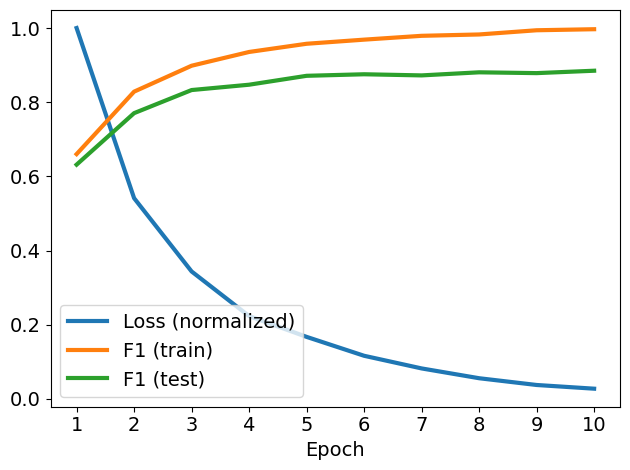

In [24]:
plot_training_results(results, legend=['Loss (normalized)', 'F1 (train)', 'F1 (test)'])

From the results and the plot you can see that our model overall trains very well: both the loss and the training f1 score greatly improve even in just 10 epochs. In fact, we see an almost perfect training f1 score of $1.0$. In some sense, this is not surprising as this task is arguably a very simple one since predicting the category of a news headline is unlikely to require a deeper understanding of the text. For example, simply the presence of words such as "budget" or "stock" are probably already strong indicators of a headline belonging to a business article. The test f1 score improves equally well, but does stay below the train f1 score. Again, this difference is not very surprising. Overall, the dataset is not very large. This means that splitting it into a training and test set is likely to yield in the situation where many words in the testset are not in the training set and therefore not known to the model.

---

## Discussion

In this notebook, we went through a complete practical example of training and evaluating a RNN-based text classification model. We loaded and prepared the dataset for the training, and then created and trained a model over this dataset. The focus was elaborating on and understanding the steps required as well as highlight potential caveats. The goal was not to achieve any state-of-the-art results. As such, simplifications and restrictions included:

**Simple task & small data.** On can argue the task of predicting the news category for a given deadline is rather simple since the category can most likely reliably predicted by the presence or absence of words in a headline &mdash; that is, the actual word or is not that important to actually warrant the use of an RNN compared more traditional text classification models (g.e., Multinomial Naive Bayes). Also, given the size of the dataset and the vocabulary baseline models such as Naive Bayes are likely to perform equally well. However, the focus here was to go through a sample practical example, to cover the most importants steps and challenges when training an RNN for text classification. This includes the choice of a small dataset so that training remains reasonably fast even when using only the CPU (instead of a GPU)

**Simple model.** In some sense, we implemented and trained the most basic RNN-based model for text classification tasks. Only by using an LSTM layer instead of the Vanilla layer, we have made our model slightly more sophisticated. Of course, there are many straightforward extension to the model once can explore to see if they yield better prediction results, including but no limited to:
* *Additional linear hidden layers.* Our current model only uses a single additional linear hidden layer between the LSTM and the output layer. Additional hidden layers in a neural network help with learning by enabling the model to capture and represent more complex patterns and hierarchical relationships in the data. In deep networks, the first few layers typically learn simple features (such as edges in image processing or common word patterns in text), while deeper layers progressively combine these features into more abstract and meaningful representations. This hierarchical learning allows the network to understand intricate structures that a shallow network might struggle to capture. More hidden layers can also improve the network's ability to approximate complex functions, making it more powerful for tasks such as image recognition, language processing, and decision-making. However, deeper networks require careful tuning, as they are more prone to overfitting and require more data and computational resources.
* *Additional Dropout layer.* A Dropout layer is a regularization technique used in neural networks to prevent overfitting by randomly setting a fraction of the neurons to zero during training. This means that at each training step, a specified percentage (e.g., $20\%$ or $50\%$) of the neurons in the layer are temporarily "dropped out", forcing the network to learn more robust and generalized patterns rather than relying on specific neurons. By preventing co-adaptation of neurons, dropout improves the model’s ability to generalize to unseen data, leading to better performance on validation and test sets. During inference (i.e., when making predictions), all neurons are used, but their outputs are scaled based on the dropout rate to maintain consistency with training.
* *Bidirectional LSTM layer.* A Bidirectional LSTM (BiLSTM) layer is an extension of the standard unidirectional LSTM we have used, where the model processes the input sequence in both forward and backward directions. In a unidirectional LSTM, information flows only from past to future, meaning it can only use previous context to make predictions. In contrast, a BiLSTM consists of two LSTM layers: one processes the sequence from start to end, while the other processes it from end to start. This allows the model to capture dependencies from both past and future contexts, making it particularly useful for tasks where understanding the entire context is crucial, such as machine translation, named entity recognition, and text classification. By leveraging information from both directions, a BiLSTM can improve accuracy and capture long-range dependencies more effectively than a unidirectional LSTM. However, it also requires more computational resources due to the doubled number of parameters. While a bidirectional LSTM can easily be implemented in PyTorch by setting `bidirectional=True` when defining the [`nn.LSTM`](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) layer, it would also require additional changes in the `forward()` method of the model.
* *Multilayer LSTM layer.* A multilayer LSTM (also known as a stacked LSTM) consists of multiple LSTM layers stacked on top of each other, where the output of one LSTM layer serves as the input for the next. In contrast, a single-layer LSTM has only one LSTM layer processing the input sequence before producing an output. The key benefit of a multilayer LSTM is its ability to capture more complex hierarchical patterns in sequential data. The lower layers typically learn basic features, while deeper layers extract higher-level, abstract representations, allowing the model to understand more intricate dependencies. However, stacking multiple LSTM layers increases computational complexity and the risk of overfitting, requiring careful tuning of hyperparameters and regularization techniques like dropout. Again, PyTorch's [`nn.LSTM`](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) class allows setting the number of stacked layers using the `num_layers` parameter in the constructor.

**Pretrained word embeddings.** In our model, the weights of the embedding layer are randomly initialized and updated during the training. In contrast to a random initialization, would also initialize the weights using pretrained word embedding vectors. Using pretrained word embedding vectors in a text classification model offers several advantages, particularly in improving accuracy and reducing training time. Pretrained embeddings, such as Word2Vec, GloVe, or FastText, are trained on massive text corpora and capture rich semantic relationships between words. Instead of learning word representations from scratch, a model can leverage these embeddings to start with a strong foundation of word meanings and contextual similarities. This is especially beneficial when working with limited labeled data, as pretrained embeddings help the model generalize better by incorporating knowledge from large, diverse text sources. Another key benefit is that pretrained embeddings can capture synonymy and contextual similarities between words. This often leads to faster convergence and better generalization, making pretrained embeddings a powerful tool for text classification tasks such as sentiment analysis, spam detection, and topic categorization.

**No hyperparameter tuning.** Throughout this notebook we only considered a single data processing/preparation and the model training setup, and did not explore how a different set up may have affected the results &mdash; including different preprocessing steps, different vocabulary size, different sizes for the embedding and hidden layer, different activation functions, and so on. For example, this task might benefit from removing stopwords, increasing the size of the vocabulary, or increasing the size of the embedding and/or hidden layer. Performing hyperparameter tuning to potentially find the parameters values that maximize test f1 score is relatively straightforward conceptually, but it would add a substantial amount of training time. And this was just not within the scope of this notebook.

In short, there are many ways to build upon and potentially improve on the approach for training an RNN-based model for headline classification presented in this notebook. That being said, the core step that we have covered here would remain the same, mainly:

* Encoding the headlines into lists of token indices using a vocabulary
* Using padding and packing to support batch processing a sequences with different lengths
* Creating a model by defining all its layers and how an input batch is pushed through all layers to get the model output
* Training the model using the common iterative processing using the support of the PyTorch library

Extensions such as a more complex model architecture or performing hyperparameter tuning to find the best model would naturally require additional code and training time, but would not substantially change these core steps.

---

## Summary

Recurrent Neural Networks (RNNs) are a type of artificial neural network designed to handle sequential data, making them well-suited for text classification tasks. Unlike traditional feedforward networks, RNNs have loops that allow information to persist, enabling them to capture dependencies between words in a sequence. This capability is particularly useful in natural language processing (NLP) tasks, where understanding the context and order of words is essential. For example, an RNN can be used to classify emails as spam or non-spam based on their content, sentiment classification of customer reviews, or categorization of news articles by topic.

To better grasp how RNNs work in text classification, it is highly beneficial to go through a simple practical example. Implementing an RNN step by step allows learners to see how data preprocessing, tokenization, embedding layers, and training work in practice. It also provides insight into how hyperparameters like learning rates, sequence lengths, and hidden unit sizes impact performance. By running a small-scale experiment, one can observe firsthand how the network learns from textual data, makes predictions, and improves through backpropagation.

Additionally, working through an example helps in understanding the challenges involved, such as handling imbalanced datasets, overfitting, and choosing appropriate evaluation metrics. Practical implementation encourages experimentation with variations like Long Short-Term Memory (LSTM) networks or Gated Recurrent Units (GRUs), which address some of the shortcomings of vanilla RNNs. Overall, applying RNNs in a hands-on manner reinforces theoretical concepts and builds confidence in using deep learning for text classification tasks.